<a href="https://colab.research.google.com/github/xoloshibu/Analitics/blob/master/Ejercicio%20clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejercicio de clustering aplicado a la base de datos de housing
-- ##Carlos Alfredo Vergara Rojas

Importamos librerias, base de datos y funciones desde DRIVE

In [0]:
# Acceso al drive para importar librerias y datos:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Bd_housing = '1FYbUuP9Yvb3fdJTwZWiuhr5Sl1eD8PvG' 
downloaded = drive.CreateFile({'id': Bd_housing})
downloaded.GetContentFile('housing.csv') 


Funciones = '1RK1rfMWxgoaF1LLm0yp8vD5JSSbk6xCs' 
downloaded = drive.CreateFile({'id': Funciones})
downloaded.GetContentFile('Funciones.py') 

# LECTURA DE BASE DE DATOS CON PANDAS
from Funciones import pre_exploratorio_housing
Bd=pd.read_csv('housing.csv')
Bd.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


 Luego hacemos análisis exploratorio 


In [0]:
# IMPORTACIÓN DE LIBRERIAS NECESARIAS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# PARTCIÓN: 70% xtrain, 30% test
Xtrain, Xtest = train_test_split(Bd,test_size=0.3,random_state=42)

# COLUMNA DE SALIDA, COLUMNAS NUMÉRICAS Y COLUMNAS CATEGÓRICAS
col_sal='median_house_value'
col_num=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms',
        'population','households','median_income']
col_cat=['ocean_proximity']

# FUNCIÓN PARA COMPLETAR FALTANTES XTRAIN Y XTEST
Xtrain, Ytrain= pre_exploratorio_housing(Xtrain,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')
Xtest, Ytest= pre_exploratorio_housing(Xtest,col_sal,col_num,col_cat,estra_num='median',estra_cat='most_frequent')

# CODIFICACIÓN DE COLUMNAS CATEGÓRICAS
codificador = OrdinalEncoder()
Xtrain['ocean_proximity'].value_counts()
Xtrain['ocean_proximity'] = codificador.fit_transform(Xtrain[['ocean_proximity']])


Realizamos MEMMAP a los datos de entrenamiento.

In [0]:
# SE ESCRIBE LOS DATOS DE LA BASE A MEMMAP
from sklearn.cluster import MiniBatchKMeans
from tempfile import mkdtemp
import os.path as path
filename = path.join(mkdtemp(), 'BD_memmap.data')
X_mm     = np.memmap(filename, dtype='float32', mode='write', shape=Xtrain.shape)
X_mm[:]  = Xtrain

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)


MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Realizamos la curva elbow

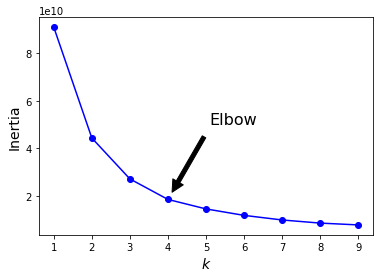

In [0]:
#  ELBOW CURVE
from sklearn.cluster import KMeans 
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(Xtrain)
                for k in range(1, 10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

Obtenemos scores de silueta para diferentes número de grupos

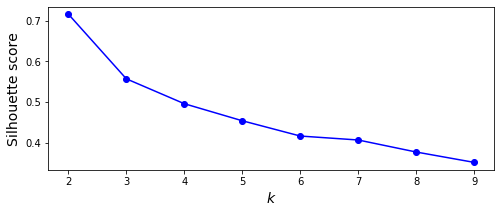

In [0]:

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_scores = [silhouette_score(Xtrain, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

Diagrama de silueta

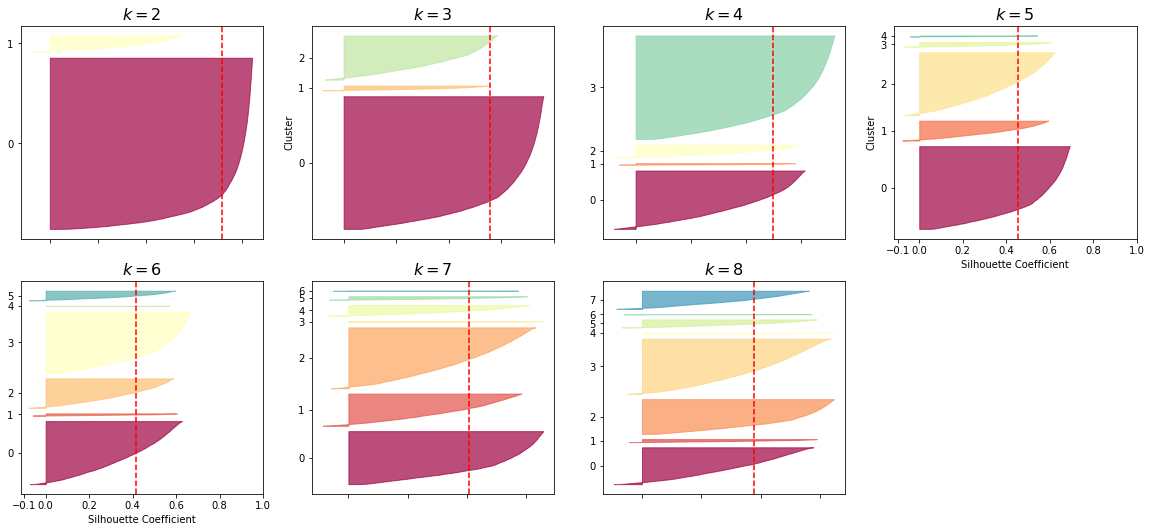

In [0]:

import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(20, 18))

for k in (2, 3, 4, 5, 6, 7, 8):
    plt.subplot(4, 4, k - 1)    
    y_pred                  = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(Xtrain, y_pred)
    padding = len(Xtrain) // 30
    pos     = padding
    ticks   = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
#save_fig("silhouette_analysis_plot")
plt.show()

Usamos PCA para reducir la dimension de las variables

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 14448 samples in 0.026s...
[t-SNE] Computed neighbors for 14448 samples in 2.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14448
[t-SNE] Computed conditional probabilities for sample 2000 / 14448
[t-SNE] Computed conditional probabilities for sample 3000 / 14448
[t-SNE] Computed conditional probabilities for sample 4000 / 14448
[t-SNE] Computed conditional probabilities for sample 5000 / 14448
[t-SNE] Computed conditional probabilities for sample 6000 / 14448
[t-SNE] Computed conditional probabilities for sample 7000 / 14448
[t-SNE] Computed conditional probabilities for sample 8000 / 14448
[t-SNE] Computed conditional probabilities for sample 9000 / 14448
[t-SNE] Computed conditional probabilities for sample 10000 / 14448
[t-SNE] Computed conditional probabilities for sample 11000 / 14448
[t-SNE] Computed conditional probabilities for sample 12000 / 14448
[t-SNE] Computed conditional probabilities for sa

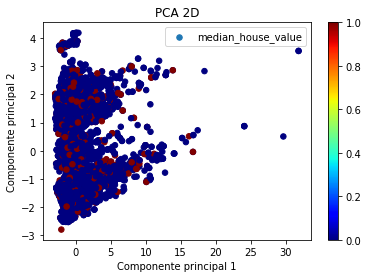

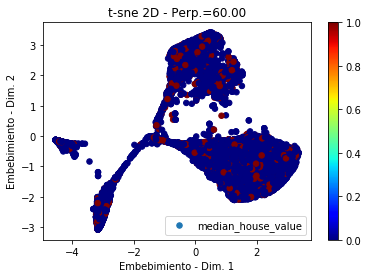

In [0]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def pre_exploratorio(Xtrain,ytrain,col_sal,y_pred,Np=None):
    
    normalizar = StandardScaler()
    #escoger aleatoriamente puntos para evitar costo computacional - analisis inicial
    if Np == None: Np = len(Xtrain.index) 
    #escoger subconjunto de datos   
    ind = np.random.randint(0,len(Xtrain.index),Np)     
    Xz = normalizar.fit_transform(Xtrain.iloc[ind,:])
    #yc = ytrain[ind].reshape(-1)
    
  
    red_pca = PCA(n_components=2) 
    perplexity = np.round(0.5*np.sqrt(Np))
    red_tsne = TSNE(n_components=2,perplexity = perplexity, n_iter = 250,verbose = 10)

    Xred_pca = pd.DataFrame(red_pca.fit_transform(Xz)) 
    Xred_tsne = pd.DataFrame(red_tsne.fit_transform(Xz))

    # PCA
    sval = 30
    Xred_pca.plot(kind="scatter",x=0,y=1,
               c = y_pred, s=sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('PCA 2D')
    plt.xlabel('Componente principal 1')
    plt.ylabel('Componente principal 2')
    plt.show() 

    # TSNE
    Xred_tsne.plot(kind="scatter",x=0,y=1,
               c = y_pred, s = sval, label = col_sal,
              colormap = "jet",colorbar=True, sharex=False)    
    plt.title('t-sne 2D - Perp.=%.2f' % perplexity)
    plt.xlabel('Embebimiento - Dim. 1')
    plt.ylabel('Embebimiento - Dim. 2')
    #save_fig(path_img,"tsne_2D")
    plt.show() 
    return Xred_pca 
    return True

Xred_pca=pre_exploratorio(Xtrain,Ytrain,col_sal,y_pred)

In [0]:
nombre_grupos=[kmeans_k3, kmeans_k4, kmeans_k5, kmeans_k6, kmeans_k7, kmeans_k8]
nombre_grupos[0].fit(Xtrain)
len(nombre_grupos)

6

Usamos los datos de pca para hacer kmeans con 4,5,6,7 y 8 grupos

In [0]:
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

k      = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(Xred_pca)
y_pred = kmeans.fit_predict(Xred_pca)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [0]:
y_pred is kmeans.labels_


True

In [0]:
kmeans.cluster_centers_

array([[ 4.02700853,  0.14936077],
       [-0.53379881, -0.01979847]])

In [0]:
Xred_pca.shape


(14448, 2)

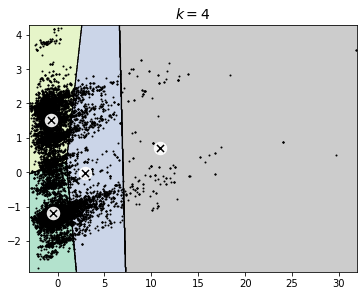

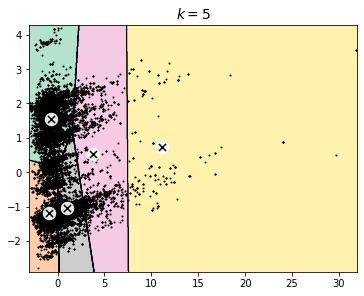

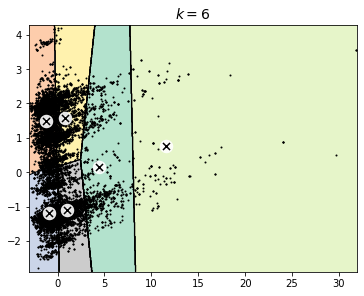

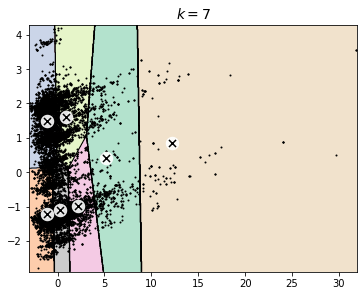

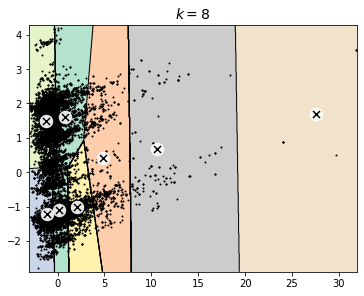

In [0]:
##Definimos fonteras de desicion y graficamos

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)
    


def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    

def plot_clusterer_comparison(nombre_grupos,Xtrain,titulos):
    for i in range(1,len(nombre_grupos)):
      clusterer=nombre_grupos[i].fit(Xtrain)
      plt.figure(figsize=(20, 10))
      plt.subplot(2,3,i)
      plot_decision_boundaries(clusterer,X=Xtrain)
      plt.title(titulos[i], fontsize=14)


kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k4 = KMeans(n_clusters=4, random_state=42)
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
kmeans_k6 = KMeans(n_clusters=6, random_state=42)
kmeans_k7 = KMeans(n_clusters=7, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)


nombre_grupos=[kmeans_k3, kmeans_k4, kmeans_k5, kmeans_k6, kmeans_k7, kmeans_k8]
titulos=["$k=3$", "$k=4$", "$k=5$", "$k=6$", "$k=7$", "$k=8$"]


plot_clusterer_comparison(nombre_grupos,np.array(Xred_pca),titulos)
#save_fig("bad_n_clusters_plot")
plt.show()